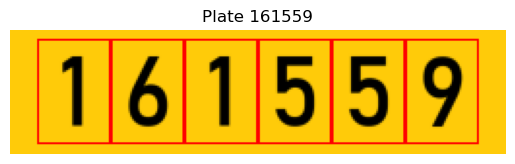

In [23]:
import h5py
import cv2
import matplotlib.pyplot as plt

# Path to your HDF5 file
h5_path = r"data/unique.h5"

# Which sample to display
img_id = 5

with h5py.File(h5_path, "r") as f:
    # load the RGB plate (uint8 H×W×3)
    img_rgb = f["original"][img_id]
    # load the plate text (numpy.str_ or bytes)
    plate_number = f["plate_number"][img_id].astype(str)
    # load the digit bounding boxes (Nx4 array)
    bboxes = f["digit_bboxes"][img_id]

# draw the bounding boxes (in-place on the NumPy array)
for x, y, w, h in bboxes:
    # note: cv2.rectangle expects BGR, but since we're only drawing on the array
    # we'll pretend it's already in BGR order—the color tuple is still (B,G,R).
    cv2.rectangle(img_rgb, (x, y), (x + w - 1, y + h - 1), (255, 0, 0), 1)

# display with matplotlib (which expects RGB)
plt.figure()
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Plate {plate_number}")
plt.show()


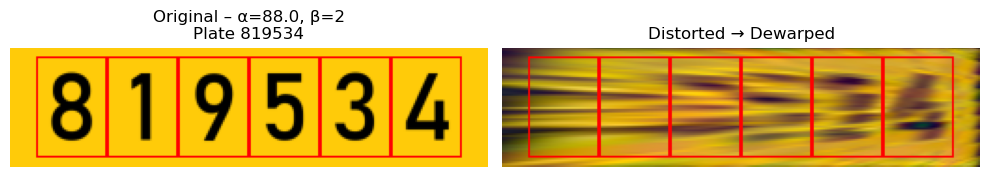

In [37]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Path to your HDF5 file
h5_path = "data/full_grid.h5"

# Desired angles (floats, to one decimal place if that’s how they were stored)
desired_alpha = 88.0
desired_beta  = 2

with h5py.File(h5_path, "r") as f:
    # Load all angle arrays
    alphas = f["alpha"][:]  # shape: (N_samples,)
    betas  = f["beta"][:]   # shape: (N_samples,)

    # Find all indices matching the desired pair
    # Use np.isclose in case of floating‐point rounding
    mask = np.isclose(alphas, desired_alpha) & np.isclose(betas, desired_beta)
    indices = np.where(mask)[0]

    if len(indices) == 0:
        raise ValueError(f"No samples found for alpha={desired_alpha}, beta={desired_beta}")
    
    # For demo, take the first matching sample
    idx = indices[0]

    # Load images and metadata for that sample
    img_orig = f["original"][idx]         # uint8 H×W×3 RGB
    img_dist = f["distorted"][idx]        # uint8 H×W×3 RGB
    plate_no = f["plate_number"][idx].astype(str)
    bboxes   = f["digit_bboxes"][idx]     # array of shape (num_digits, 4)

# Function to draw boxes on a copy of the image
def draw_boxes(img, bboxes, color=(255, 0, 0), thickness=1):
    out = img.copy()
    for x, y, w, h in bboxes:
        # cv2.rectangle expects BGR, but since we're only marking,
        # the tuple ordering still works on RGB arrays.
        cv2.rectangle(out, (x, y), (x + w - 1, y + h - 1), color, thickness)
    return out

# Draw boxes on both images
orig_boxed = draw_boxes(img_orig, bboxes)
dist_boxed = draw_boxes(img_dist, bboxes)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_boxed)
axes[0].set_title(f"Original – α={desired_alpha}, β={desired_beta}\nPlate {plate_no}")
axes[0].axis("off")

axes[1].imshow(dist_boxed)
axes[1].set_title("Distorted → Dewarped")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [18]:
import os, json, cv2, math
from concurrent.futures import ThreadPoolExecutor, as_completed
from tesserocr import PyTessBaseAPI, OEM, PSM
from PIL import Image

# ── CONFIG ────────────────────────────────────────────────────────────
TRAIN_DIR     = r"C:\Users\stopc\Desktop\LPR_Project\data\val"
METADATA_PATH = os.path.join(TRAIN_DIR, "metadata.json")
N_WORKERS     = 8                              # threads to spawn

# ── LOAD METADATA ─────────────────────────────────────────────────────
with open(METADATA_PATH, "r") as f:
    records = json.load(f)

# ── WORKER FUNCTION ───────────────────────────────────────────────────
def process_chunk(chunk):
    """
    OCR all plates in <chunk> (list of metadata dicts).
    Returns: (digit_ok, digit_total, plate_ok, plate_total, lines)
    """
    with PyTessBaseAPI(oem=OEM.LSTM_ONLY, psm=PSM.SINGLE_WORD) as api:
        api.SetVariable("tessedit_char_whitelist", "0123456789")
        api.SetVariable("load_system_dawg", "0")
        api.SetVariable("load_freq_dawg", "0")

        dig_ok = dig_tot = pl_ok = pl_tot = 0
        out_lines = []

        for rec in chunk:
            idx   = rec["index"]
            truth = rec["plate_number"]
            img   = cv2.imread(os.path.join(TRAIN_DIR, f"original_{idx}.png"))
            if img is None:
                out_lines.append(f"Plate {idx:4d} | [MISSING IMAGE]")
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, bin_ = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

            ocr_str = ""
            for i, (x, y, w, h) in enumerate(rec["digit_bboxes"]):

                patch = bin_[y:y+h, x:x+w]
                # convert NumPy array to PIL for tesserocr
                patch_pil = Image.fromarray(patch)
                api.SetImage(patch_pil)
                    
                txt = api.GetUTF8Text().strip()
                digit = txt[0] if txt and txt[0].isdigit() else ""
                ocr_str += digit

                dig_tot += 1
                if digit == truth[i]:
                    dig_ok += 1

            if ocr_str == truth:
                pl_ok += 1
            pl_tot += 1

            status = "OK" if ocr_str == truth else "ERR"
            out_lines.append(f"Plate {idx:4d} | GT={truth} | OCR={ocr_str:<6} | {status}")

        return dig_ok, dig_tot, pl_ok, pl_tot, out_lines

# ── SPLIT WORK & RUN THREADS ──────────────────────────────────────────
chunk_size = math.ceil(len(records) / N_WORKERS)
chunks = [records[i:i+chunk_size] for i in range(0, len(records), chunk_size)]

digit_ok = digit_tot = plate_ok = plate_tot = 0
all_lines = []

with ThreadPoolExecutor(max_workers=N_WORKERS) as exe:
    futures = [exe.submit(process_chunk, c) for c in chunks]
    for fut in as_completed(futures):
        d_ok, d_tot, p_ok, p_tot, lines = fut.result()
        digit_ok  += d_ok
        digit_tot += d_tot
        plate_ok  += p_ok
        plate_tot += p_tot
        all_lines.extend(lines)

# ── PRINT DETAIL (comment out if too verbose) ─────────────────────────
for ln in sorted(all_lines):
    print(ln)

# ── SUMMARY ───────────────────────────────────────────────────────────
print("\nRESULTS")
print(f"  Digit‑level accuracy: {digit_ok / digit_tot * 100:.2f}% "
      f"({digit_ok}/{digit_tot})")
print(f"  Plate‑level accuracy: {plate_ok / plate_tot * 100:.2f}% "
      f"({plate_ok}/{plate_tot})")


Plate    0 | GT=688126 | OCR=688126 | OK
Plate    1 | GT=340319 | OCR=340319 | OK
Plate    2 | GT=012846 | OCR=012846 | OK
Plate    3 | GT=965515 | OCR=965515 | OK
Plate    4 | GT=492181 | OCR=492181 | OK
Plate    5 | GT=914514 | OCR=914514 | OK
Plate    6 | GT=056177 | OCR=056177 | OK
Plate    7 | GT=332430 | OCR=332430 | OK
Plate    8 | GT=060557 | OCR=060557 | OK
Plate    9 | GT=798237 | OCR=798237 | OK
Plate   10 | GT=759042 | OCR=759042 | OK
Plate   11 | GT=030998 | OCR=030998 | OK
Plate   12 | GT=845936 | OCR=845936 | OK
Plate   13 | GT=155139 | OCR=155139 | OK
Plate   14 | GT=060971 | OCR=060971 | OK
Plate   15 | GT=220941 | OCR=220941 | OK
Plate   16 | GT=410642 | OCR=410642 | OK
Plate   17 | GT=830474 | OCR=830474 | OK
Plate   18 | GT=189587 | OCR=189587 | OK
Plate   19 | GT=147466 | OCR=147466 | OK
Plate   20 | GT=487154 | OCR=487154 | OK
Plate   21 | GT=222176 | OCR=222176 | OK
Plate   22 | GT=571492 | OCR=571492 | OK
Plate   23 | GT=488530 | OCR=488530 | OK
Plate   24 | GT=

In [27]:
import os
import math
import cv2
import numpy as np
import h5py
from concurrent.futures import ThreadPoolExecutor, as_completed
from tesserocr import PyTessBaseAPI, OEM, PSM
from PIL import Image

# ── CONFIG ────────────────────────────────────────────────────────────
H5_PATH   = r"data/train.h5"    # path to your HDF5 validation split
N_WORKERS = 8                 # number of threads

# ── PRELOAD ENTIRE DATASET INTO MEMORY ─────────────────────────────────
with h5py.File(H5_PATH, "r") as f:
    orig_arr   = f["original"][:]        # shape (N, H, W, 3), uint8 RGB
    plate_arr  = f["plate_number"][:]    # shape (N,), fixed‐length UTF8 strings
    bbox_arr   = f["digit_bboxes"][:]    # shape (N, digits, 4), int32

total_samples = orig_arr.shape[0]
indices       = list(range(total_samples))
chunk_size    = math.ceil(total_samples / N_WORKERS)
chunks        = [
    indices[i : i + chunk_size]
    for i in range(0, total_samples, chunk_size)
]

# ── WORKER FUNCTION ───────────────────────────────────────────────────
def process_chunk(idxs,
                  orig_arr=orig_arr,
                  plate_arr=plate_arr,
                  bbox_arr=bbox_arr):
    """
    OCR all plates in the given list of indices.
    Returns:
      (digit_ok, digit_tot, plate_ok, plate_tot, out_lines)
    """
    dig_ok = dig_tot = pl_ok = pl_tot = 0
    out_lines = []

    # initialize Tesseract once per worker
    with PyTessBaseAPI(oem=OEM.LSTM_ONLY, psm=PSM.SINGLE_WORD) as api:
        api.SetVariable("tessedit_char_whitelist", "0123456789")
        api.SetVariable("load_system_dawg", "0")
        api.SetVariable("load_freq_dawg", "0")

        for idx in idxs:
            truth = plate_arr[idx].astype(str)
            img_rgb = orig_arr[idx]  # already in RAM, shape H×W×3

            # convert to grayscale + binary mask
            gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
            _, bin_ = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

            # OCR each digit patch
            ocr_str = ""
            for i, (x, y, w, h) in enumerate(bbox_arr[idx]):
                patch = bin_[y : y + h, x : x + w]
                patch_pil = Image.fromarray(patch)
                api.SetImage(patch_pil)
                txt = api.GetUTF8Text().strip()
                digit = txt[0] if txt and txt[0].isdigit() else ""
                ocr_str += digit

                dig_tot += 1
                if digit == truth[i]:
                    dig_ok += 1

            # plate-level decision
            pl_tot += 1
            status = "OK" if ocr_str == truth else "ERR"
            if ocr_str == truth:
                pl_ok += 1

            out_lines.append(
                f"Plate {idx:4d} | GT={truth} | OCR={ocr_str:<6} | {status}"
            )

    return dig_ok, dig_tot, pl_ok, pl_tot, out_lines

# ── RUN THREAD POOL ────────────────────────────────────────────────────
digit_ok = digit_tot = plate_ok = plate_tot = 0
all_lines = []

with ThreadPoolExecutor(max_workers=N_WORKERS) as exe:
    futures = [exe.submit(process_chunk, chunk) for chunk in chunks]
    for fut in as_completed(futures):
        d_ok, d_tot, p_ok, p_tot, lines = fut.result()
        digit_ok  += d_ok
        digit_tot += d_tot
        plate_ok  += p_ok
        plate_tot += p_tot
        all_lines.extend(lines)

# ── DETAIL PRINT (optional) ─────────────────────────────────────────────
for ln in sorted(all_lines):
    print(ln)

# ── SUMMARY ───────────────────────────────────────────────────────────
print("\nRESULTS")
print(f"  Digit-level accuracy: {digit_ok / digit_tot * 100:.2f}% ({digit_ok}/{digit_tot})")
print(f"  Plate-level accuracy: {plate_ok / plate_tot * 100:.2f}% ({plate_ok}/{plate_tot})")


Plate    0 | GT=797908 | OCR=797908 | OK
Plate    1 | GT=695986 | OCR=695986 | OK
Plate    2 | GT=620116 | OCR=620116 | OK
Plate    3 | GT=212872 | OCR=212872 | OK
Plate    4 | GT=698492 | OCR=698492 | OK
Plate    5 | GT=610902 | OCR=610902 | OK
Plate    6 | GT=024418 | OCR=024418 | OK
Plate    7 | GT=919019 | OCR=919019 | OK
Plate    8 | GT=755872 | OCR=755872 | OK
Plate    9 | GT=215094 | OCR=215094 | OK
Plate   10 | GT=529181 | OCR=529181 | OK
Plate   11 | GT=475607 | OCR=475607 | OK
Plate   12 | GT=691521 | OCR=691521 | OK
Plate   13 | GT=294186 | OCR=294186 | OK
Plate   14 | GT=790201 | OCR=790201 | OK
Plate   15 | GT=120518 | OCR=120518 | OK
Plate   16 | GT=747561 | OCR=747561 | OK
Plate   17 | GT=013639 | OCR=013639 | OK
Plate   18 | GT=649965 | OCR=649965 | OK
Plate   19 | GT=650282 | OCR=650282 | OK
Plate   20 | GT=303435 | OCR=303435 | OK
Plate   21 | GT=336630 | OCR=336630 | OK
Plate   22 | GT=780100 | OCR=780100 | OK
Plate   23 | GT=898881 | OCR=898881 | OK
Plate   24 | GT=

In [3]:
%matplotlib qt

In [6]:
%matplotlib inline

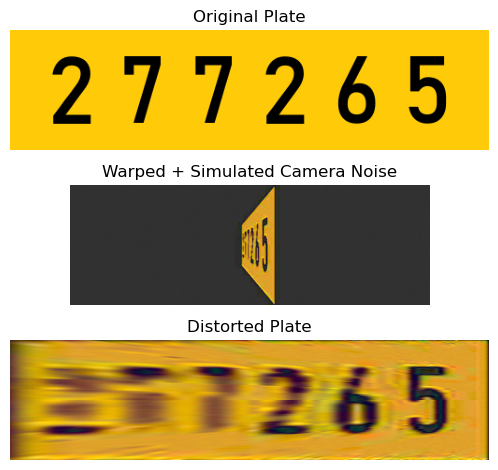

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
from src.lp_processing import (
    create_license_plate,
    warp_image,
    simulate_noise,
    dewarp_image,
    crop_to_original_size,
)

random.seed(100)
np.random.seed(100)

# --- Test parameters (now 256×64 plates) ---
alpha, beta = 84, 0
width, height = 512, 128
text_size = 100
focal_length = width  # matches production f=original_width

# 1. Create a clean plate (PIL image in RGB) and get its corners
plate_pil, src_points, plate_number, _ = create_license_plate(width, height, text_size)

# 2. PIL → NumPy (RGB)
plate_rgb = np.array(plate_pil)

# 3. Warp (expects RGB, returns RGB)
warped_rgb, dst_points = warp_image(plate_rgb, np.array(src_points), alpha, beta, focal_length)

# 4. Noise (expects RGB, returns RGB)
noisy_rgb = simulate_noise(warped_rgb)

# 5. Dewarp (expects RGB, returns RGB)
dewarped_rgb = dewarp_image(noisy_rgb, src_points, dst_points)

orig_crop   = crop_to_original_size(plate_rgb,   width, height)
dewarp_crop = crop_to_original_size(dewarped_rgb, width, height)

fig, axes = plt.subplots(3, 1)

axes[0].imshow(orig_crop)
axes[0].axis('off')
axes[0].set_title(f'Original Plate')

axes[1].imshow(noisy_rgb)
axes[1].axis('off')
axes[1].set_title('Warped + Simulated Camera Noise')

axes[2].imshow(dewarp_crop)
axes[2].axis('off')
axes[2].set_title(f'Distorted Plate')

plt.tight_layout()
plt.show()


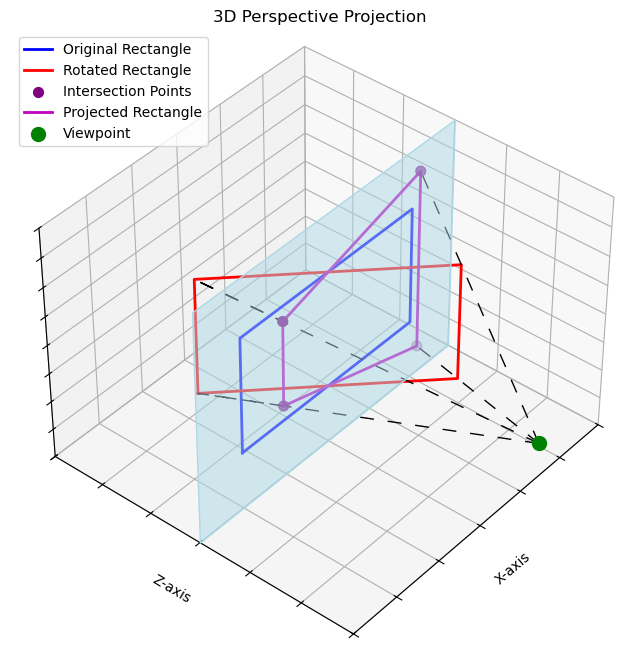

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def rotate_around_y(points, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rotation_matrix = np.array([
        [cos_a, 0, sin_a],
        [0,     1, 0    ],
        [-sin_a, 0, cos_a]
    ])
    return points @ rotation_matrix.T

def intersect_line_with_plane(p1, p2, plane_z=0):
    t = (plane_z - p1[2]) / (p2[2] - p1[2])
    intersection = p1 + t * (p2 - p1)
    return intersection

# Original rectangle in the xy-plane (z=0)
rectangle = np.array([
    [-1, -1, 0],  # Bottom-left
    [ 1, -1, 0],  # Bottom-right
    [ 1,  1, 0],  # Top-right
    [-1,  1, 0]   # Top-left
])

# Define the plane (larger rectangle in the xy-plane)
plane = np.array([
    [-1.5, -2, 0],  # Bottom-left
    [ 1.5, -2, 0],  # Bottom-right
    [ 1.5,  2, 0],  # Top-right
    [-1.5,  2, 0]   # Top-left
])

# Rotate the rectangle around the Y-axis by 45 degrees
rotated_rectangle = rotate_around_y(rectangle, angle_deg=45)

# Define the viewpoint (camera position)
viewpoint = np.array([0, 0, -2])

# Compute intersections with the z=0 plane
intersections = np.array([
    intersect_line_with_plane(rotated_rectangle[i], viewpoint)
    for i in range(len(rotated_rectangle))
])

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the plane with bluish tint
plane_verts = [list(zip(plane[:, 0], plane[:, 2], plane[:, 1]))]  # Swap Y and Z axes
plane_collection = Poly3DCollection(plane_verts, color='lightblue', alpha=0.5)
ax.add_collection3d(plane_collection)

# Plot the original rectangle
original_rect_closed = np.vstack([rectangle, rectangle[0]])
ax.plot(
    original_rect_closed[:, 0],   # X-axis data
    original_rect_closed[:, 2],   # Y-axis data (use Z data)
    original_rect_closed[:, 1],   # Z-axis data (use Y data)
    'b-', linewidth=2, label='Original Rectangle'
)

# Plot the rotated rectangle
rotated_rect_closed = np.vstack([rotated_rectangle, rotated_rectangle[0]])
ax.plot(
    rotated_rect_closed[:, 0],
    rotated_rect_closed[:, 2],    # Y-axis data (use Z data)
    rotated_rect_closed[:, 1],    # Z-axis data (use Y data)
    'r-', linewidth=2, label='Rotated Rectangle'
)

# Plot dashed lines from the viewpoint through rotated rectangle to intersection points
for i in range(len(rotated_rectangle)):
    xs = [viewpoint[0], rotated_rectangle[i, 0], intersections[i, 0]]
    ys = [viewpoint[2], rotated_rectangle[i, 2], intersections[i, 2]]
    zs = [viewpoint[1], rotated_rectangle[i, 1], intersections[i, 1]]
    ax.plot(xs, ys, zs, 'k--', linewidth=1, dashes=[10, 10])

# Plot the intersection points
ax.scatter(
    intersections[:, 0],
    intersections[:, 2],    # Y-axis data (use Z data)
    intersections[:, 1],    # Z-axis data (use Y data)
    color='purple', s=50, label='Intersection Points'
)

# Connect intersection points to form the projected rectangle
intersections_closed = np.vstack([intersections, intersections[0]])
ax.plot(
    intersections_closed[:, 0],
    intersections_closed[:, 2],    # Y-axis data (use Z data)
    intersections_closed[:, 1],    # Z-axis data (use Y data)
    'm-', linewidth=2, label='Projected Rectangle'
)

# Plot the viewpoint
ax.scatter(
    viewpoint[0],
    viewpoint[2],    # Y-axis data (use Z data)
    viewpoint[1],    # Z-axis data (use Y data)
    color='g', s=100, label='Viewpoint'
)

# Set labels and title
ax.set_title('3D Perspective Projection')
ax.set_xlabel('X-axis')
ax.set_ylabel('Z-axis')  # Reflects swapped axes in plotting
ax.set_zlabel('Y-axis')  # Reflects swapped axes in plotting
ax.legend()

# Adjust the viewing angle
ax.view_init(elev=40, azim=-140)

# Adjust axis limits if necessary
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-2, 2)

# Hide axis tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

# Display the plot
plt.show()